# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]
    
## Problem Statements:
- Which areas have high / low traffic demand?
- How does regional traffic demand change according to day / time?
- Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### This is for model training and testing

#### Import python library

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

# plot matplotlib graph
%matplotlib inline

#Import models from scikit learn module:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

import h5py
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger

import pickle
import joblib
import os

from ModelDefinitions import createModel

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [10]:
    #***********************************
    # Index 00-10 is for LSTM Model
    # Index 11-20 is for Bi-LSTM Model
    # Index 21-30 is for CNN Model
    # Index 31-40 is for CNN-LSTM Model
    #***********************************

# choose a number of time steps
n_steps_in, predict_next_no_of_output = 3, 2

# ------ CHANGE THESE ------
index = 12
seed  = 7
np.random.seed(seed)
basemodelname = 'BiLSTM2-' + str(n_steps_in) + 'in' + str(predict_next_no_of_output) + 'out'
batch_size    = 4096
no_of_epoch   = 20
no_of_train   = 0.8
# --------------------------

modelname = basemodelname + "_" + str(index)
filepath  = 'model/' + modelname + ".hdf5"

## Define Functions

In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


## Read in Dataset

In [5]:
xls  = pd.ExcelFile('data/Dataset_feature.xlsx')
data = pd.read_excel(xls, 'TrafficMgmt')
data

day      hour       min       dow       lat      long    demand
0        0.283333  0.869565  0.000000  0.285714  0.533333  0.171429  0.020072
1        0.150000  0.608696  0.666667  0.285714  0.288889  0.200000  0.024721
2        0.133333  0.260870  0.333333  0.142857  0.644444  0.828571  0.102821
3        0.516667  0.217391  0.000000  0.000000  0.533333  0.428571  0.088755
4        0.233333  0.173913  0.000000  1.000000  0.288889  0.342857  0.074468
...           ...       ...       ...       ...       ...       ...       ...
1048570  0.083333  0.347826  0.666667  0.857143  0.911111  0.771429  0.024022
1048571  0.366667  0.652174  0.666667  1.000000  0.111111  0.400000  0.005703
1048572  0.683333  0.652174  1.000000  0.285714  0.533333  0.200000  0.067131
1048573  0.016667  0.260870  0.666667  0.285714  0.711111  0.600000  0.151323
1048574  0.066667  0.434783  1.000000  0.714286  0.688889  0.800000  0.026007

[1048575 rows x 7 columns]

In [6]:
predictor_var = ['day','hour','min','dow','lat','long']
outcome_var   = 'demand'
no_of_features = len(predictor_var)

#### Prepare training & test data

In [7]:
# convert into input/output
dataset = data.to_numpy()
X, y = split_sequences(dataset, n_steps_in, predict_next_no_of_output)
    
# Train-test-val dataset split
X_train1 = X[:int(no_of_train*len(X))]
y_train1 = y[:int(no_of_train*len(X))]
X_test  = X[int(no_of_train*len(X)):]
y_test  = y[int(no_of_train*len(X)):]

X_train = X_train1[:int(no_of_train*len(X_train1))]
y_train = y_train1[:int(no_of_train*len(X_train1))]
X_val   = X_train1[int(no_of_train*len(X_train1)):]
y_val   = y_train1[int(no_of_train*len(X_train1)):]


In [8]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(671085, 3, 6) (671085, 2) (209715, 3, 6) (209715, 2) (167772, 3, 6) (167772, 2)


### Main Program

In [11]:
def main():
    
    #***********************************
    # Index 00-10 is for LSTM Model
    # Index 11-20 is for Bi-LSTM Model
    # Index 21-30 is for CNN Model
    # Index 31-40 is for CNN-LSTM Model
    #***********************************

    # Create model and summary
    model = createModel(X_train, predict_next_no_of_output, index) #
    model.summary()
    
    # Create checkpoint for the training
    # This checkpoint performs model saving when
    # an epoch gives highest testing accuracy  
    checkpoint     = ModelCheckpoint(filepath, monitor='val_loss',verbose=0,save_best_only=True,mode='min') 
    
    # Log the epoch detail into csv
    csv_logger     = CSVLogger('model/' + modelname + '.csv')
    callbacks_list = [checkpoint,csv_logger]

    # steps_per_epoch = total training data across all classes / batch size
    # validation_steps = number of batches in validation dataset defining 1 epoch
    # The line for training
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=no_of_epoch, 
                        batch_size=batch_size,
                        shuffle=False,
                        callbacks=callbacks_list) 

main()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 3, 256)            138240    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 256)            1024      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 3, 512)            1050624   
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 512)            2048      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 3, 512)            1574912   
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 512)            2048  

### Load saved trained model and scalar

In [12]:
# Load your own trained model & scaler
model           = load_model(filepath, compile = False)
scaler_filename = "grab_msft_scaler.save"
scaler          = joblib.load(scaler_filename) 

### Test dataset test result

In [13]:
predicted_value = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,predicted_value)))

0.15694234058204343


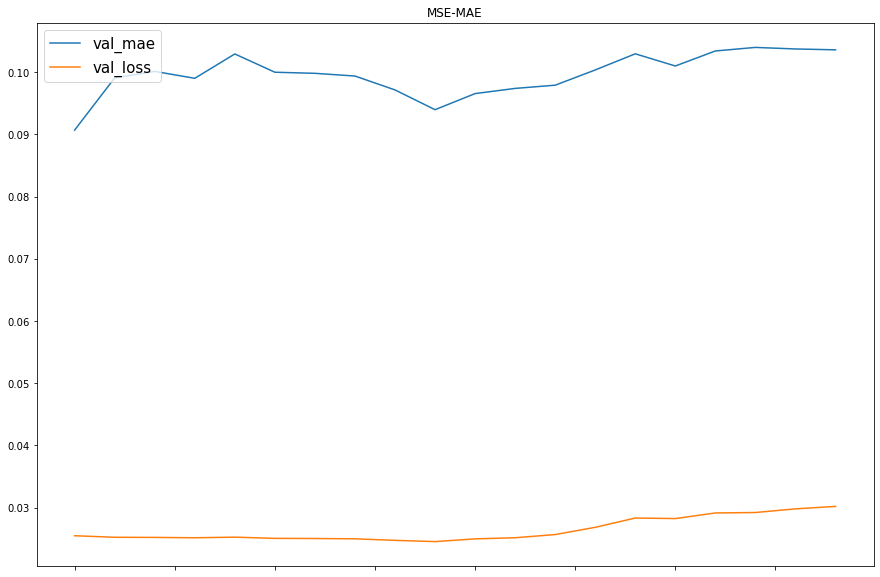

In [20]:
records     = pd.read_csv('model/' + modelname +'.csv')
plt.figure(figsize=(15,10))

ax          = plt.gca()
ax.set_xticklabels([])

plt.plot(records['val_mae'],label="val_mae")
plt.plot(records['val_loss'],label="val_loss")
plt.title('MSE-MAE',fontsize=12)
plt.legend(loc="upper left",fontsize=15)

plt.show()

### Sample Testing 

In [15]:
xls  = pd.ExcelFile('data/test_sample8000.xlsx')
test_sample = pd.read_excel(xls, 'TrafficMgmt')

# Apply Standardscalar to sample test data
test_sample[predictor_var] = scaler.fit_transform(test_sample[predictor_var])

In [16]:
# covert into input/output
test_sample_array = test_sample.to_numpy()
X_sample, y_sample = split_sequences(test_sample_array, n_steps_in, predict_next_no_of_output)
print(X_sample.shape, y_sample.shape)

(17, 3, 6) (17, 2)


In [17]:
predicted_value = model.predict(X_sample)
print('Predicted value : {} \n Actual Value    : {}' .format(predicted_value,y_sample))

Predicted value : [[0.04148225 0.10368152]
 [0.08324113 0.1030051 ]
 [0.09822959 0.10315566]
 [0.10947694 0.10248573]
 [0.04912844 0.10041381]
 [0.07135849 0.10337912]
 [0.05669135 0.10004953]
 [0.05740327 0.09993549]
 [0.06804968 0.10313583]
 [0.08680887 0.09722792]
 [0.09694195 0.11348223]
 [0.08033751 0.10290202]
 [0.09715539 0.10274015]
 [0.14031976 0.10711963]
 [0.1338743  0.10562874]
 [0.0491998  0.10088255]
 [0.07642791 0.10342173]] 
 Actual Value    : [[4.11381160e-02 6.28299090e-02]
 [6.28299090e-02 1.59614780e-01]
 [1.59614780e-01 9.09941638e-01]
 [9.09941638e-01 9.01061000e-04]
 [9.01061000e-04 1.32621545e-01]
 [1.32621545e-01 1.93137866e-01]
 [1.93137866e-01 4.08696860e-02]
 [4.08696860e-02 2.04278450e-02]
 [2.04278450e-02 6.94884150e-02]
 [6.94884150e-02 4.17434120e-02]
 [4.17434120e-02 1.90697068e-01]
 [1.90697068e-01 2.86340264e-01]
 [2.86340264e-01 6.49010570e-02]
 [6.49010570e-02 9.24329596e-01]
 [9.24329596e-01 7.57118120e-02]
 [7.57118120e-02 5.34953510e-02]
 [5.3495

In [18]:
print(np.sqrt(mean_squared_error(y_sample,predicted_value)))

0.28506055093979815
